# Allocate renewable resources to the bus

Convert CRS from ESPG:4326 (lat/lon) to ESPG:32618 (UTM 18N)

Nearest neighbor distance calculation in meters.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
from shapely.geometry import LineString
from nygrid.allocate import nearest_neighbor_meters
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

gis_data_dir = os.path.join(data_dir, 'gis')
if not os.path.exists(gis_data_dir):
    raise FileNotFoundError('GIS data directory not found.')

thermal_data_dir = os.path.join(data_dir, 'thermal')
if not os.path.exists(thermal_data_dir):
    raise FileNotFoundError('Thermal data directory not found.')

print('GIS data directory: {}'.format(gis_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

GIS data directory: /mnt/Bo_HDD/NYgrid-python/data/gis
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures


## NY Grid

In [3]:
# Read shapefile of NYISO zone map
nyiso_zone = gpd.read_file(os.path.join(gis_data_dir, 'NYISO Load Zone.shp'))
nyiso_zone = nyiso_zone.set_index('FID')
nyiso_zone_32618 = nyiso_zone.to_crs(epsg=32618)

# Read shapefile of NYGrid buses
nygrid_bus = gpd.read_file(os.path.join(gis_data_dir, 'Bus.shp'))
nygrid_bus = nygrid_bus.set_index('fid')
# Drop columns that are not needed
nygrid_bus = nygrid_bus[['busIdx', 'busType', 'zone', 'geometry']]
# Convert bus type to category
nygrid_bus['busType'] = pd.Categorical(nygrid_bus['busType'])
nygrid_bus_32618 = nygrid_bus.to_crs(epsg=32618)

# Filter out external buses
nygrid_bus_ny = nygrid_bus[nygrid_bus['zone'] != 0]
nygrid_bus_ny_32618 = nygrid_bus_ny.to_crs(epsg=32618)

# Read shapefile of NYGrid branches
nygrid_branch = gpd.read_file(os.path.join(gis_data_dir, 'Branch.shp'))
nygrid_branch_32618 = nygrid_branch.to_crs(epsg=32618)

# Read shapefile of NYGrid generators
nygrid_generator = gpd.read_file(os.path.join(gis_data_dir, 'Generator.shp'))
nygrid_generator_32618 = nygrid_generator.to_crs(epsg=32618)

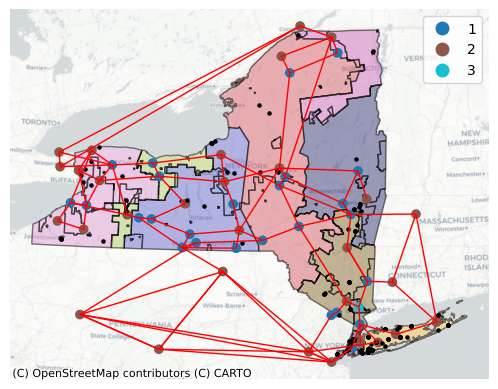

In [4]:
# NYISO zone map
ax = nyiso_zone_32618.plot('ZONE_NAME', cmap='tab20b',
                           alpha=0.5, edgecolor='k')

# NYGrid buses, branches, and generators
nygrid_bus_32618.plot(ax=ax, column='busType', legend=True)
nygrid_branch_32618.plot(ax=ax, color='red', linewidth=1)
nygrid_generator_32618.plot(ax=ax, color='black', markersize=5)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=nygrid_bus_32618.crs)
ax.set_axis_off()

## NYS counties

In [5]:
# Read NYS county shapefile
counties = gpd.read_file(os.path.join(gis_data_dir, 'Counties_Shoreline.shp'))
counties_32618 = counties.to_crs(epsg=32618)

# Get the centroid of each county
counties_32618['centroid'] = counties_32618.centroid
county_centroids_32618 = counties_32618.copy().set_geometry('centroid')
county_centroids_32618.head()

NAME ABBREV GNIS_ID FIPS_CODE    SWIS    NYSP_ZONE  POP1990  \
0       Albany   ALBA  974099     36001  010000         East   292594   
1     Allegany   ALLE  974100     36003  020000         West    50470   
2        Bronx   BRON  974101     36005  600000  Long Island  1203789   
3       Broome   BROO  974102     36007  030000      Central   212160   
4  Cattaraugus   CATT  974103     36009  040000         West    84234   

   POP2000  POP2010  POP2020  DOS_LL  DOSLL_DATE NYC   CALC_SQ_MI     DATEMOD  \
0   294565   304204   314848     NaN         NaN   N   532.791779  2017-11-10   
1    49927    48946    46456     NaN         NaN   N  1035.209131  2019-04-26   
2  1332650  1385108  1472654     NaN         NaN   Y    41.933548  2019-10-04   
3   200536   200600   198683     NaN         NaN   N   715.287465  2019-04-26   
4    83955    80317    77042     NaN         NaN   N  1324.309219  2019-04-26   

      Shape_Leng    Shape_Area  \
0  166077.834242  1.379924e+09   
1  210499.339279  2.681179e+09   
2  119895.489494  1.086074e+08   
3  227933.332021  1.852586e+09   
4  276084.505560  3.429945e+09   

                                            geometry  \
0  POLYGON ((608219.067 4737612.214, 608193.476 4...   
1  POLYGON ((250192.891 4712087.227, 250192.436 4...   
2  MULTIPOLYGON (((593044.686 4516671.633, 593025...   
3  POLYGON ((465447.452 4671514.148, 465436.974 4...   
4  POLYGON ((215534.305 4715146.657, 215536.193 4...   

                         centroid  
0  POINT (584193.738 4716921.586)  
1  POINT (250264.724 4682768.919)  
2  POINT (595486.238 4523010.496)  
3  POINT (432307.936 4667905.823)  
4  POINT (196488.790 4683926.011)

In [6]:
# Nearest neighbor allocation
closest_bus = nearest_neighbor_meters(county_centroids_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
county_centroids_2bus_32618 = county_centroids_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
county_centroids_2bus_32618['link'] = county_centroids_2bus_32618.apply(
    lambda row: LineString([row['centroid'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
county_centroids_links_32618 = county_centroids_2bus_32618.copy()
county_centroids_links_32618 = county_centroids_links_32618.set_geometry(
    'link').set_crs(epsg=32618)

In [7]:
county_centroids_out = county_centroids_2bus_32618.copy()
county_centroids_out = county_centroids_out.set_geometry('centroid')
county_centroids_out = county_centroids_out.drop(columns=[
    'geometry', 'closest_bus_geom', 'link', 'distance',
    'Shape_Leng', 'Shape_Area', 'DOS_LL', 'DOSLL_DATE'])
county_centroids_out = county_centroids_out.to_crs(epsg=4326)
county_centroids_out['zone'] = county_centroids_out['zone'].replace(
    {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H',
     9: 'I', 10: 'J', 11: 'K'})

# Save the allocation to CSV
county_centroids_out.to_csv(os.path.join(data_dir,
                                         'load',
                                         'county_centroids_2bus.csv'),
                            index=False)

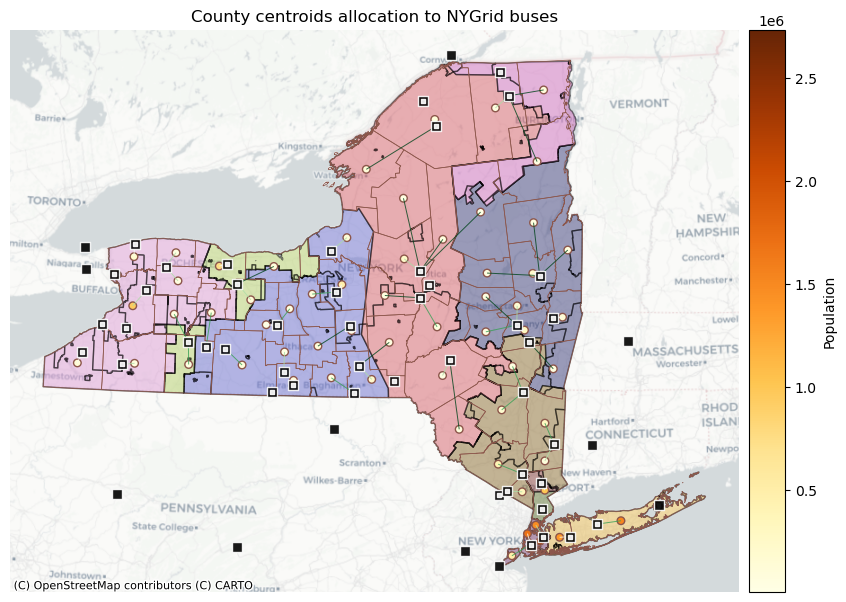

In [39]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')

ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=0.5)

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = county_centroids_32618.plot(column='POP2020', cmap='YlOrBr', edgecolor='tab:brown',
                                 legend=True, ax=ax, cax=cax, markersize=30,
                                 legend_kwds={'label': 'Population'})

ax = county_centroids_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                       scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=county_centroids_32618.crs)
ax.title.set_text('County centroids allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'county_centroids_allocation.png'), dpi=600,
            bbox_inches='tight')

## AQ stations

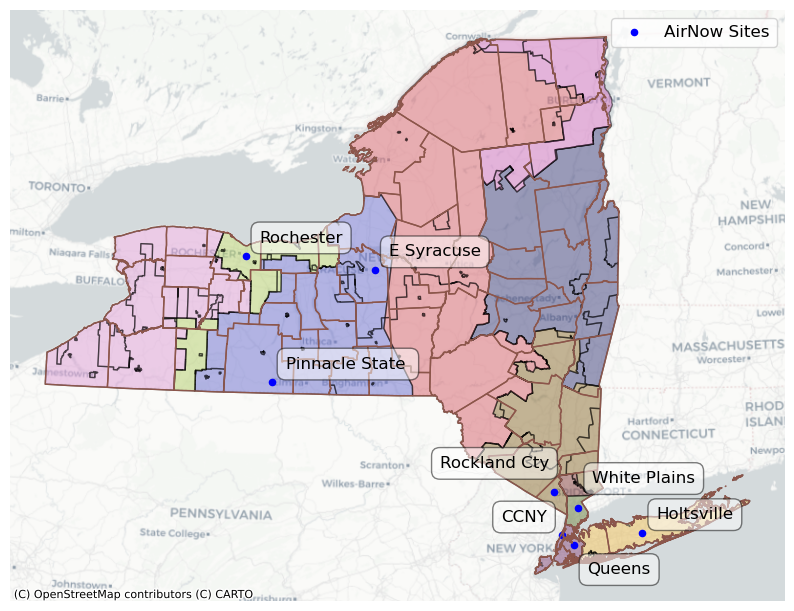

In [9]:
name = ['CCNY', 'E Syracuse', 'Holtsville', 'Pinnacle State ', 'Queens',
        'Rochester', 'Rockland Cty', 'White Plains']
lat = [40.81973, 43.05235, 40.82799, 42.09115, 40.73625, 43.14618,
       41.1821, 41.05189]
lon = [-73.94823, -76.05918, -73.05754, -77.20988, -73.82165, -77.54821,
       -74.02816, -73.76364]
airnow_sites = pd.DataFrame({'name': name, 'lat': lat, 'lon': lon})
airnow_sites = gpd.GeoDataFrame(
    airnow_sites, geometry=gpd.points_from_xy(airnow_sites.lon, airnow_sites.lat))
airnow_sites.crs = 'EPSG:4326'
airnow_sites_32618 = airnow_sites.to_crs(epsg=32618)

fig, ax = plt.subplots(figsize=(10, 10))
ax = nyiso_zone_32618.plot('ZONE_NAME', cmap='tab20b',
                           alpha=0.5, edgecolor='k', ax=ax)
airnow_sites_32618.plot(ax=ax, color='blue',
                        markersize=20, label='AirNow Sites')
# Counties boundaries
ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=1)

for i, txt in enumerate(airnow_sites['name']):
    x = airnow_sites_32618.geometry.x[i]
    y = airnow_sites_32618.geometry.y[i]
    if txt == 'CCNY':
        x -= 70000
    elif txt == 'Queens':
        y -= 40000
    elif txt == 'Rockland Cty':
        x -= 120000
        y += 10000
    elif txt == 'White Plains':
        y += 10000
    ax.annotate(txt, (x, y),
                xytext=(10, 10), textcoords='offset points', color='black', fontsize=12,
                bbox=dict(facecolor='white', boxstyle='round,pad=0.5', alpha=0.5))

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=nygrid_bus_32618.crs)
ax.set_axis_off()
plt.legend(fontsize=12)
plt.savefig(os.path.join(fig_dir, 'weather_aq_stations.png'), dpi=300)

## Thermal generators

In [10]:
gen_combiner = pd.read_excel(os.path.join(thermal_data_dir, '2018_nyca_thermal.xlsx'),
                             sheet_name='matched_with_id_filtered')
gen_combiner = gen_combiner.rename(columns={
    '   Station        Unit': 'NYISO_Name',
})

# Map unit type GT, JE to CT
gen_combiner['Unit Type'] = gen_combiner['Unit Type'].replace(
    {'GT': 'CT', 'JE': 'CT'})
gen_combiner['Fuel Type Secondary'] = gen_combiner['Fuel Type Secondary'].astype(
    str).replace({'nan': ''})
gen_combiner['Unit and Fuel Type'] = gen_combiner['Unit Type'] + \
    ' ' + gen_combiner['Fuel Type Primary'] + \
    ' ' + gen_combiner['Fuel Type Secondary']

In [11]:
# Turn into geodataframe
gen_info = gpd.GeoDataFrame(gen_combiner,
                            geometry=gpd.points_from_xy(gen_combiner['EIA_Longitude'],
                                                        gen_combiner['EIA_Latitude']),
                            crs='EPSG:4326')
# Set CRS
gen_info = gen_info.set_crs(epsg=4326)
gen_info_32618 = gen_info.to_crs(epsg=32618)

gen_info.head()

NYISO_Name Zone   PTID  Name Plate Rating (MW) Dual Fuel Unit Type  \
0      Danskammer 1    G  23586                    72.0       YES        ST   
1      Danskammer 2    G  23589                    73.5       YES        ST   
2      Danskammer 3    G  23590                   147.1       NaN        ST   
3      Danskammer 4    G  23591                   239.4       NaN        ST   
4  Arthur Kill ST 2    J  23512                   376.2       NaN        ST   

  Fuel Type Primary Fuel Type Secondary  2017 Net Energy (GWh) Note  ...  \
0                NG                 FO6                0.93040  NaN  ...   
1                NG                 FO6                0.90830  NaN  ...   
2                NG                                    2.06448  NaN  ...   
3                NG                                    5.05390  NaN  ...   
4                NG                                  563.62800  NaN  ...   

  CAMD_Generator_ID CAMD_Nameplate_Capacity        CAMD_Fuel_Type  \
0                 1                    72.0  Pipeline Natural Gas   
1                 2                    73.5  Pipeline Natural Gas   
2                 3                   147.1  Pipeline Natural Gas   
3                 4                   239.4  Pipeline Natural Gas   
4                 2                   376.2  Pipeline Natural Gas   

  EIA_Latitude EIA_Longitude         ID eco_min_ratio_obs  gen_bus  \
0    41.571247    -73.974981   (2480,1)              0.50       77   
1    41.571247    -73.974981   (2480,2)              0.50       77   
2    41.571247    -73.974981   (2480,3)              0.50       77   
3    41.571247    -73.974981   (2480,4)              0.50       77   
4    40.591564    -74.200035  (2490,20)              0.28       82   

   Unit and Fuel Type                    geometry  
0           ST NG FO6  POINT (-73.97498 41.57125)  
1           ST NG FO6  POINT (-73.97498 41.57125)  
2              ST NG   POINT (-73.97498 41.57125)  
3              ST NG   POINT (-73.97498 41.57125)  
4              ST NG   POINT (-74.20003 40.59156)  

[5 rows x 24 columns]

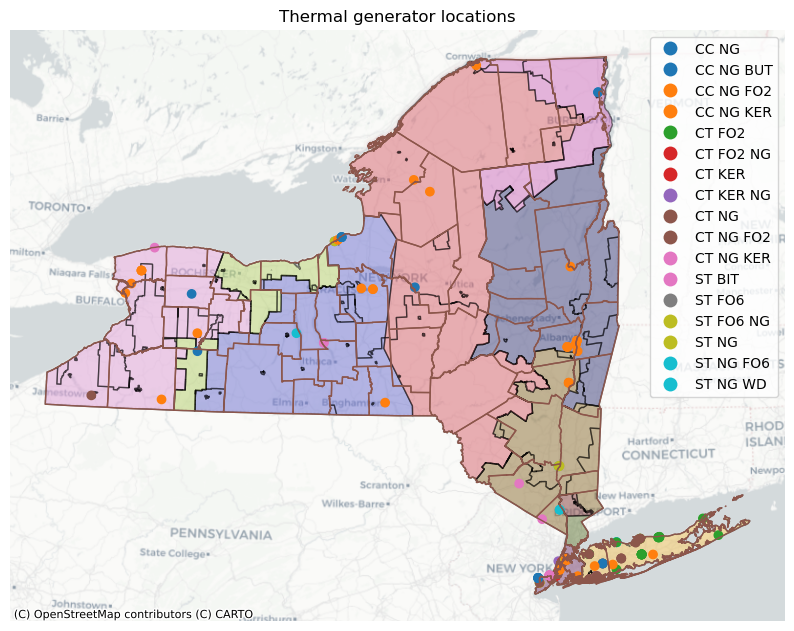

In [12]:
# Shop locations in a map
fig, ax = plt.subplots(figsize=(10, 8))
ax = nyiso_zone_32618.plot('ZONE_NAME', cmap='tab20b',
                           alpha=0.5, edgecolor='k', ax=ax)
ax = gen_info_32618.plot(ax=ax, column='Unit and Fuel Type', legend=True,
                         legend_kwds={'loc': 'upper right'})
# Counties boundaries
ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=1)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=gen_info_32618.crs)
ax.title.set_text('Thermal generator locations')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'thermal_generator_locations.png'), dpi=600,
            bbox_inches='tight')

In [13]:
gen_info_with_counties = gpd.sjoin(
    gen_info_32618, counties_32618, how='left', predicate='within')
gen_info_with_counties = gen_info_with_counties[[
    'NYISO_Name', 'NAME']].rename(columns={'NAME': 'County'})
display(gen_info_with_counties)

# Save the allocation to CSV
gen_info_with_counties.to_csv(os.path.join(data_dir,
                                           'grid',
                                           'thermal_gen_2_county.csv'))

NYISO_Name    County
0        Danskammer 1    Orange
1        Danskammer 2    Orange
2        Danskammer 3    Orange
3        Danskammer 4    Orange
4    Arthur Kill ST 2  Richmond
..                ...       ...
231  Bayonne EC  CTG4       NaN
232  Bayonne EC  CTG5       NaN
233  Bayonne EC  CTG6       NaN
234  Bayonne EC  CTG7       NaN
235  Bayonne EC  CTG8       NaN

[236 rows x 2 columns]

## Current UPV solar farms

In [14]:
current_upv_farms = [
    'upv_params_2024_ft',
    'upv_params_2024_sat',
]

# Process current solar farm parameters
current_upv_farm_list = []
for group in current_upv_farms:
    upv_farm = pd.read_excel(os.path.join(data_dir, 'renewable', 'solar_projects.xlsx'),
                             sheet_name=group)
    upv_farm = upv_farm[['Name', 'p_cap_ac', 'p_county', 'lat', 'lon']]

    # Replace 'St Lawrence' with 'St. Lawrence'
    upv_farm['p_county'] = upv_farm['p_county'].replace(
        {'St Lawrence': 'St. Lawrence'})

    # UPV from NYSERDA supply curve
    if group == 'upv_params_state_scenario_2030':
        upv_farm['Name'] = 'UPV ' + upv_farm['Name']

    current_upv_farm_list.append(upv_farm)

current_upv_info = pd.concat(current_upv_farm_list, axis=0)
current_upv_info = current_upv_info.reset_index(drop=True)

# Turn into geodataframe
current_upv_info = gpd.GeoDataFrame(current_upv_info,
                                    geometry=gpd.points_from_xy(current_upv_info['lon'],
                                                                current_upv_info['lat']),
                                    crs='EPSG:4326')
# Set CRS
current_upv_info = current_upv_info.set_crs(epsg=4326)
current_upv_info_32618 = current_upv_info.to_crs(epsg=32618)

In [15]:
# Nearest neighbor allocation
closest_bus = nearest_neighbor_meters(current_upv_info_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True,
                                      leaf_size=40)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
current_upv_info_2bus_32618 = current_upv_info_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
current_upv_info_2bus_32618['link'] = current_upv_info_2bus_32618.apply(
    lambda row: LineString([row['geometry'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
current_upv_info_links_32618 = current_upv_info_2bus_32618.copy()
current_upv_info_links_32618 = current_upv_info_links_32618.set_geometry(
    'link').set_crs(epsg=32618)

In [16]:
current_upv_2bus = current_upv_info_2bus_32618.copy()
current_upv_2bus = current_upv_2bus.drop(
    columns=['geometry', 'closest_bus_geom', 'distance', 'link'])

current_upv_2bus['zone'] = current_upv_2bus['zone'].replace(
    {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H',
     9: 'I', 10: 'J', 11: 'K'})
current_upv_2bus = current_upv_2bus.reset_index(drop=True)

# Save the allocation to CSV
current_upv_2bus.to_csv(os.path.join(data_dir,
                                     'renewable',
                                     'solar',
                                     'current_upv_2bus.csv'))

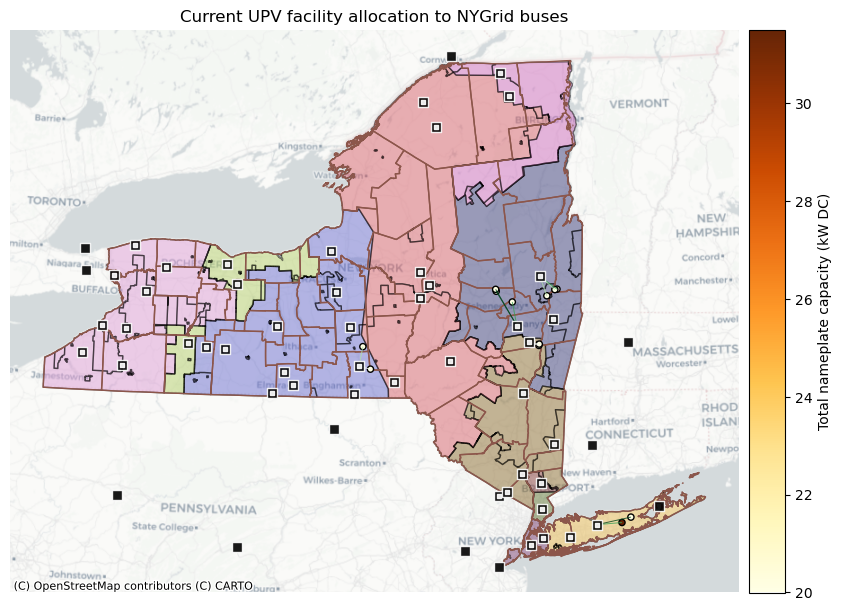

In [17]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')
# Counties boundaries
ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=1)

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = current_upv_info_32618.plot(column='p_cap_ac', cmap='YlOrBr', edgecolor='k',
                                 legend=True, ax=ax, cax=cax, markersize=20,
                                 legend_kwds={'label': 'Total nameplate capacity (kW DC)'})

ax = current_upv_info_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                       scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=current_upv_info_32618.crs)
ax.title.set_text('Current UPV facility allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'current_upv_allocation.png'), dpi=600,
            bbox_inches='tight')

## Future UPV solar farms

In [18]:
future_upv_farms = [
    'upv_params_outlook_base',
    'upv_params_outlook_contract',
    'upv_params_state_scenario_2030',
]

# Process future solar farm parameters
future_upv_farm_list = []
for group in future_upv_farms:
    upv_farm = pd.read_excel(os.path.join(data_dir, 'renewable', 'solar_projects.xlsx'),
                             sheet_name=group)
    upv_farm = upv_farm[['Name', 'p_cap_ac', 'p_county', 'lat', 'lon']]

    # Replace 'St Lawrence' with 'St. Lawrence'
    upv_farm['p_county'] = upv_farm['p_county'].replace(
        {'St Lawrence': 'St. Lawrence'})

    # UPV from NYSERDA supply curve
    if group == 'upv_params_state_scenario_2030':
        upv_farm['Name'] = 'UPV ' + upv_farm['Name']

    future_upv_farm_list.append(upv_farm)

future_upv_info = pd.concat(future_upv_farm_list, axis=0)
future_upv_info = future_upv_info.reset_index(drop=True)

# Turn into geodataframe
future_upv_info = gpd.GeoDataFrame(future_upv_info,
                                   geometry=gpd.points_from_xy(future_upv_info['lon'],
                                                               future_upv_info['lat']),
                                                               crs='EPSG:4326')
# Set CRS
future_upv_info = future_upv_info.set_crs(epsg=4326)
future_upv_info_32618 = future_upv_info.to_crs(epsg=32618)

In [19]:
# Nearest neighbor allocation to NYGrid buses
closest_bus = nearest_neighbor_meters(future_upv_info_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True,
                                      leaf_size=40)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
future_upv_info_2bus_32618 = future_upv_info_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
future_upv_info_2bus_32618['link'] = future_upv_info_2bus_32618.apply(
    lambda row: LineString([row['geometry'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
future_upv_info_links_32618 = future_upv_info_2bus_32618.copy()
future_upv_info_links_32618 = future_upv_info_links_32618.set_geometry(
    'link').set_crs(epsg=32618)

In [20]:
future_upv_2bus = future_upv_info_2bus_32618.copy()
future_upv_2bus = future_upv_2bus.drop(
    columns=['geometry', 'closest_bus_geom', 'distance', 'link'])

future_upv_2bus['zone'] = future_upv_2bus['zone'].replace(
    {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H',
     9: 'I', 10: 'J', 11: 'K'})
future_upv_2bus = future_upv_2bus.reset_index(drop=True)

# Save the allocation to CSV
future_upv_info_2bus_32618.to_csv(os.path.join(data_dir,
                                               'renewable',
                                               'solar',
                                               'future_upv_farms_2bus.csv'))

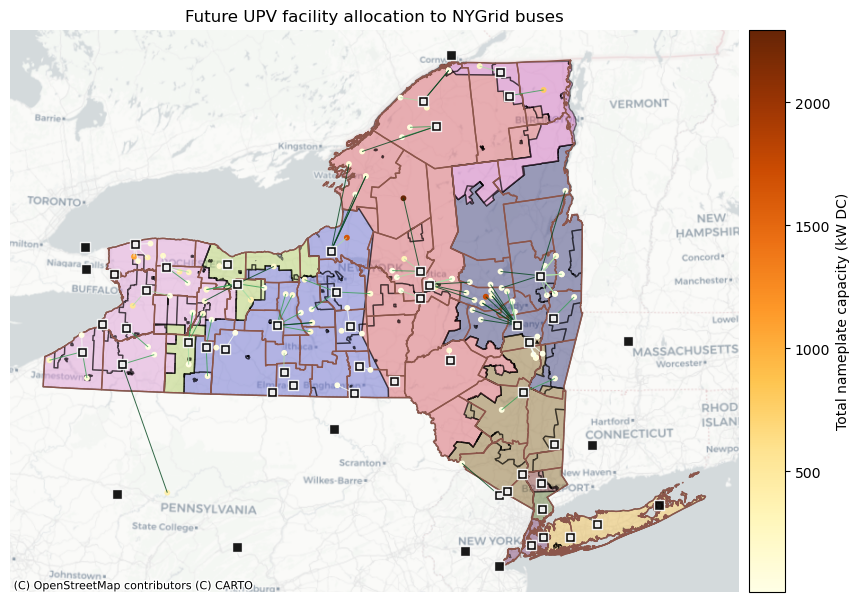

In [21]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')
# Counties boundaries
ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=1)

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = future_upv_info_32618.plot(column='p_cap_ac', cmap='YlOrBr',
                                  legend=True, ax=ax, cax=cax, markersize=10,
                                  legend_kwds={'label': 'Total nameplate capacity (kW DC)'})

ax = future_upv_info_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                      scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=future_upv_info_32618.crs)
ax.title.set_text('Future UPV facility allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'future_upv_allocation.png'), dpi=600,
            bbox_inches='tight')

## BTM PV solar farms

In [22]:
btmpv_farms = [
    'btmpv_params_baseline_2030',
    # 'btmpv_params_lower_demand_2030',
    # 'btmpv_params_higher_demand_2030',
    # 'btmpv_params_baseline_2040',
    # 'btmpv_params_lower_demand_2040',
    # 'btmpv_params_higher_demand_2040',
]

# Process solar farm parameters
btmpv_farm_list = []
for group in btmpv_farms:
    btmpv_farm = pd.read_excel(os.path.join(data_dir, 'renewable', 'solar_projects.xlsx'),
                              sheet_name=group)
    btmpv_farm = btmpv_farm[['Name', 'p_cap_ac', 'p_county', 'lat', 'lon']]

    # Replace 'St Lawrence' with 'St. Lawrence'
    btmpv_farm['p_county'] = btmpv_farm['p_county'].replace(
        {'St Lawrence': 'St. Lawrence'})
    btmpv_farm_list.append(btmpv_farm)

btmpv_info = pd.concat(btmpv_farm_list, axis=0)
btmpv_info = btmpv_info.reset_index(drop=True)

# Turn into geodataframe
btmpv_info = gpd.GeoDataFrame(btmpv_info,
                                    geometry=gpd.points_from_xy(btmpv_info['lon'],
                                                                btmpv_info['lat']),
                                    crs='EPSG:4326')
# Set CRS
btmpv_info = btmpv_info.set_crs(epsg=4326)
btmpv_info_32618 = btmpv_info.to_crs(epsg=32618)

In [23]:
# Nearest neighbor allocation
closest_bus = nearest_neighbor_meters(btmpv_info_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
btmpv_info_2bus_32618 = btmpv_info_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
btmpv_info_2bus_32618['link'] = btmpv_info_2bus_32618.apply(
    lambda row: LineString([row['geometry'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
btmpv_info_links_32618 = btmpv_info_2bus_32618.copy()
btmpv_info_links_32618 = btmpv_info_links_32618.set_geometry(
    'link').set_crs(epsg=32618)

In [24]:
btmpv_2bus = btmpv_info_2bus_32618.copy()
btmpv_2bus = btmpv_2bus.drop(
    columns=['geometry', 'closest_bus_geom', 'distance', 'link'])

btmpv_2bus['zone'] = btmpv_2bus['zone'].replace(
    {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H',
     9: 'I', 10: 'J', 11: 'K'})
btmpv_2bus = btmpv_2bus.reset_index(drop=True)

# Save the allocation to CSV
btmpv_2bus.to_csv(os.path.join(data_dir,
                                     'renewable',
                                     'solar',
                                     'btmpv_2bus.csv'))

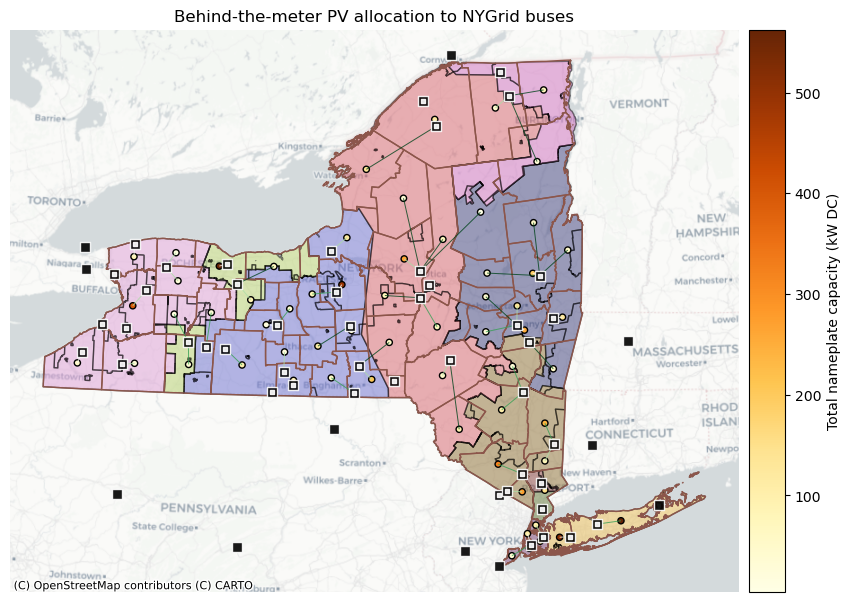

In [25]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')
# Counties boundaries
ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=1)

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = btmpv_info_32618.plot(column='p_cap_ac', cmap='YlOrBr', edgecolor='k',
                                 legend=True, ax=ax, cax=cax, markersize=20,
                                 legend_kwds={'label': 'Total nameplate capacity (kW DC)'})

ax = btmpv_info_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                       scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=btmpv_info_32618.crs)
ax.title.set_text('Behind-the-meter PV allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'btmpv_allocation.png'), dpi=600,
            bbox_inches='tight')

## Current wind farms

In [26]:
# Read onshore wind turbine locations
current_wind_info = pd.read_excel(os.path.join(data_dir,
                                             'renewable',
                                             'onshore_wind',
                                             'uswtdb_2024_ny.xlsx'))

# Turn into geodataframe
current_wind_info = gpd.GeoDataFrame(current_wind_info,
                                     geometry=gpd.points_from_xy(current_wind_info.xlong,
                                                                 current_wind_info.ylat),
                                     crs=4326)
current_wind_info_32618 = current_wind_info.to_crs(epsg=32618)

current_wind_info

case_id    faa_ors           faa_asn  usgs_pr_id   eia_id t_state  \
0     3075455  36-123725   2013-WTE-431-OE         NaN  61673.0      NY   
1     3075462  36-123732   2013-WTE-455-OE         NaN  61673.0      NY   
2     3075467  36-123737   2013-WTE-473-OE         NaN  61673.0      NY   
3     3075457  36-123727   2013-WTE-438-OE         NaN  61673.0      NY   
4     3075458  36-123728   2013-WTE-439-OE         NaN  61673.0      NY   
...       ...        ...               ...         ...      ...     ...   
1329  3052515        NaN  2015-WTE-1656-OE         NaN      NaN      NY   
1330  3086886        NaN  2016-WTE-3769-OE         NaN      NaN      NY   
1331  3086750        NaN  2016-WTE-3764-OE         NaN      NaN      NY   
1332  3077968  36-123714  2016-WTE-2715-OE         NaN      NaN      NY   
1333  3053232  36-120351  2015-WTE-5788-OE         NaN      NaN      NY   

               t_county  t_fips                     p_name  p_year  ...  \
0     Chautauqua County   36013           Arkwright Summit  2018.0  ...   
1     Chautauqua County   36013           Arkwright Summit  2018.0  ...   
2     Chautauqua County   36013           Arkwright Summit  2018.0  ...   
3     Chautauqua County   36013           Arkwright Summit  2018.0  ...   
4     Chautauqua County   36013           Arkwright Summit  2018.0  ...   
...                 ...     ...                        ...     ...  ...   
1329  Montgomery County   36057  unknown Montgomery County  2015.0  ...   
1330     Niagara County   36063     unknown Niagara County  2017.0  ...   
1331      Oneida County   36065      unknown Oneida County  2017.0  ...   
1332      Oneida County   36065      unknown Oneida County  2017.0  ...   
1333     Wyoming County   36121     unknown Wyoming County  2016.0  ...   

      t_retrofit  t_retro_yr t_offshore t_conf_atr  t_conf_loc  t_img_date  \
0              0         NaN          0          3           3  2018-09-01   
1              0         NaN          0          3           3  2018-09-01   
2              0         NaN          0          3           3  2018-09-18   
3              0         NaN          0          3           3  2018-09-01   
4              0         NaN          0          3           3  2018-09-01   
...          ...         ...        ...        ...         ...         ...   
1329           0         NaN          0          1           3  2015-11-23   
1330           0         NaN          0          1           3  2017-10-10   
1331           0         NaN          0          1           3  2018-04-21   
1332           0         NaN          0          1           3  2018-05-08   
1333           0         NaN          0          1           3  2017-05-20   

      t_img_src      xlong       ylat                    geometry  
0         Maxar -79.217438  42.390697  POINT (-79.21744 42.39070)  
1         Maxar -79.244499  42.414898  POINT (-79.24450 42.41490)  
2         Maxar -79.197357  42.379391  POINT (-79.19736 42.37939)  
3         Maxar -79.205750  42.381874  POINT (-79.20575 42.38187)  
4         Maxar -79.209778  42.382069  POINT (-79.20978 42.38207)  
...         ...        ...        ...                         ...  
1329      Maxar -74.459503  42.858387  POINT (-74.45950 42.85839)  
1330      Maxar -78.493965  43.282898  POINT (-78.49397 43.28290)  
1331      Maxar -75.448891  42.974724  POINT (-75.44889 42.97472)  
1332      Maxar -75.445847  42.976818  POINT (-75.44585 42.97682)  
1333      Maxar -78.187935  42.740818  POINT (-78.18793 42.74082)  

[1334 rows x 29 columns]

In [27]:
# Nearest neighbor allocation
closest_bus = nearest_neighbor_meters(current_wind_info_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
current_wind_info_2bus_32618 = current_wind_info_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
current_wind_info_2bus_32618['link'] = current_wind_info_2bus_32618.apply(
    lambda row: LineString([row['geometry'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
current_wind_info_links_32618 = current_wind_info_2bus_32618.copy()
current_wind_info_links_32618 = current_wind_info_links_32618.set_geometry(
    'link').set_crs(epsg=32618)


In [28]:
current_wind_2bus = current_wind_info_2bus_32618.copy()
current_wind_2bus = current_wind_2bus.drop(
    columns=['geometry', 'closest_bus_geom', 'distance', 'link'])
current_wind_2bus['zone'] = current_wind_2bus['zone'].replace(
    {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H',
     9: 'I', 10: 'J', 11: 'K'})
current_wind_2bus = current_wind_2bus.reset_index(drop=True)

# Save the allocation to CSV
current_wind_2bus.to_csv(os.path.join(data_dir,
                                      'renewable',
                                      'onshore_wind',
                                      'current_wind_2bus.csv'))

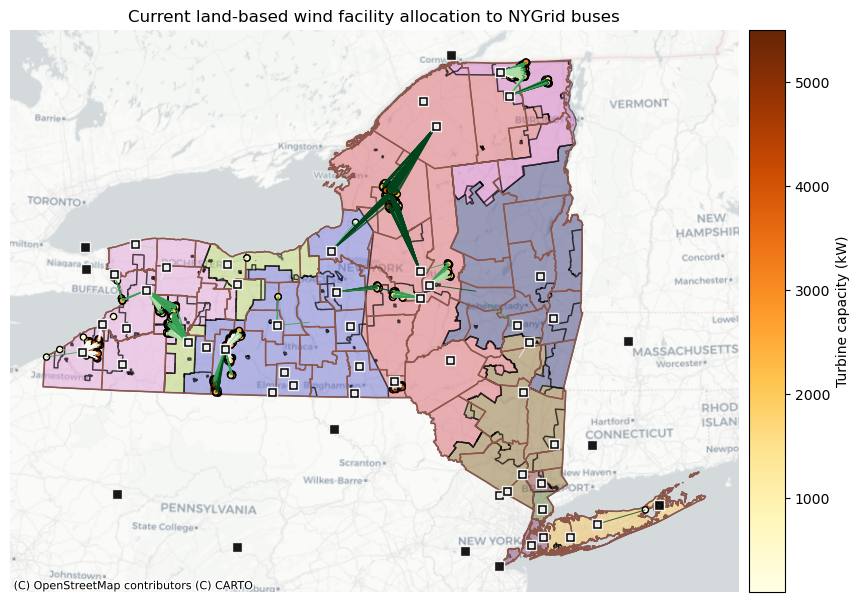

In [29]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')
# Counties boundaries
ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=1)

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = current_wind_info_32618.plot(column='t_cap', cmap='YlOrBr', edgecolor='k',
                                  legend=True, ax=ax, cax=cax, markersize=20,
                                  legend_kwds={'label': 'Turbine capacity (kW)'})

ax = current_wind_info_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                        scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=current_wind_info_32618.crs)
ax.title.set_text('Current land-based wind facility allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'current_lbw_allocation.png'), dpi=600,
            bbox_inches='tight')

## Future wind farms

In [30]:
wind_farms = [
    'lbw_params_outlook_base',
    'lbw_params_outlook_contract',
    'lbw_params_state_scenario_2030',
    'osw_farm_params',
]

osw_2030 = {
    'Empire Offshore Wind , LLC': [2076, 'Kings'],
    'Attentive Energy LLC': [1280, 'Kings'],
    'Sunrise Wind, LLC': [924, 'Nassau'],
    'Beacon Wind LLC': [1230, 'Nassau'],
    'Community Offshore Wind, LLC': [1344, 'Nassau'],
}

# Process wind farm parameters
wind_farm_list = []
for group in wind_farms:
    wind_farm = pd.read_excel(os.path.join(data_dir, 'renewable', 'wind_projects.xlsx'),
                              sheet_name=group)

    # Base case: only add High Bridge Wind
    if group == 'lbw_params_outlook_base':
        wind_farm = wind_farm[wind_farm['Name'] == 'High Bridge Wind']

    # Offshore wind
    if group == 'osw_farm_params':
        wind_farm = wind_farm[wind_farm['Name'].isin(osw_2030.keys())]
        wind_farm['p_cap'] = wind_farm['Name'].map(
            lambda x: osw_2030[x][0])
        wind_farm['p_county'] = wind_farm['Name'].map(lambda x: osw_2030[x][1])
        # Remove 'LLC' or ', LLC' from the name
        wind_farm['Name'] = wind_farm['Name'].str.replace('LLC', '').replace(
            ', ', ' ', regex=True).str.strip()
    
    # LBW from NYSERDA supply curve
    if group == 'lbw_params_state_scenario_2030':
        wind_farm['Name'] = 'LBW ' + wind_farm['Name']
    
    wind_farm_list.append(wind_farm)

future_wind_info = pd.concat(wind_farm_list, axis=0)

# Drop duplicate
future_wind_info = future_wind_info.drop_duplicates(subset=['Name'])
future_wind_info = future_wind_info.reset_index(drop=True)

# Turn into geodataframe
future_wind_info = gpd.GeoDataFrame(future_wind_info,
                                     geometry=gpd.points_from_xy(future_wind_info['lon'],
                                                                 future_wind_info['lat']),
                                     crs=4326)
future_wind_info_32618 = future_wind_info.to_crs(epsg=32618)

In [31]:
# Nearest neighbor allocation
closest_bus = nearest_neighbor_meters(future_wind_info_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
future_wind_info_2bus_32618 = future_wind_info_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
future_wind_info_2bus_32618['link'] = future_wind_info_2bus_32618.apply(
    lambda row: LineString([row['geometry'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
future_wind_info_links_32618 = future_wind_info_2bus_32618.copy()
future_wind_info_links_32618 = future_wind_info_links_32618.set_geometry(
    'link').set_crs(epsg=32618)

In [32]:
future_wind_2bus = future_wind_info_2bus_32618.copy()
future_wind_2bus = future_wind_2bus.drop(
    columns=['geometry', 'closest_bus_geom', 'distance', 'link'])
future_wind_2bus['zone'] = future_wind_2bus['zone'].replace(
    {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H',
     9: 'I', 10: 'J', 11: 'K'})
future_wind_2bus = future_wind_2bus.reset_index(drop=True)

# Save the allocation to CSV
future_wind_2bus.to_csv(os.path.join(data_dir,
                                     'renewable',
                                     'onshore_wind',
                                     'future_wind_2bus.csv'))

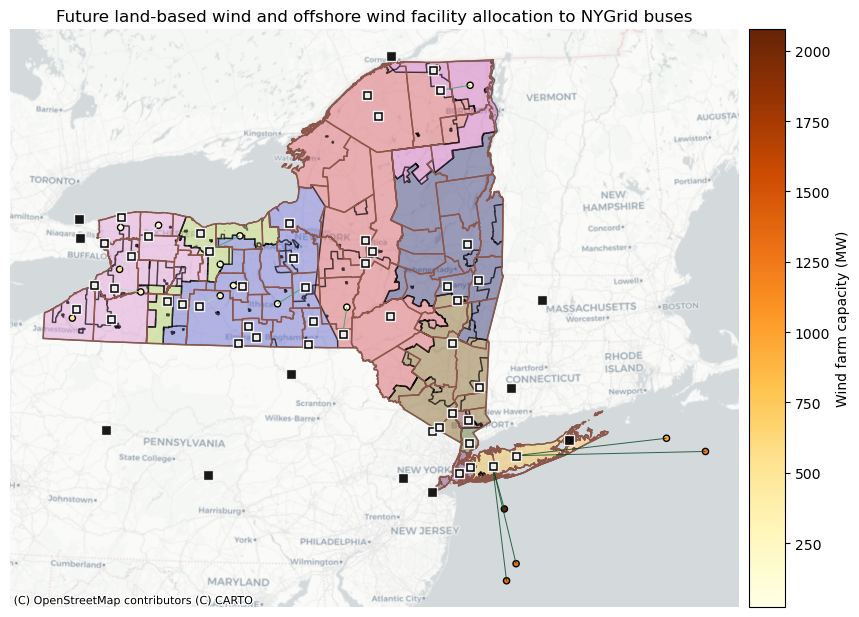

In [33]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')
# Counties boundaries
ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=1)

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = future_wind_info_32618.plot(column='p_cap', cmap='YlOrBr', edgecolor='k',
                                  legend=True, ax=ax, cax=cax, markersize=20,
                                  legend_kwds={'label': 'Wind farm capacity (MW)'})

ax = future_wind_info_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                        scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=current_wind_info_32618.crs)
ax.title.set_text('Future land-based wind and offshore wind facility allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'future_lbw_osw_allocation.png'), dpi=600,
            bbox_inches='tight')

## Map of all renewable resources

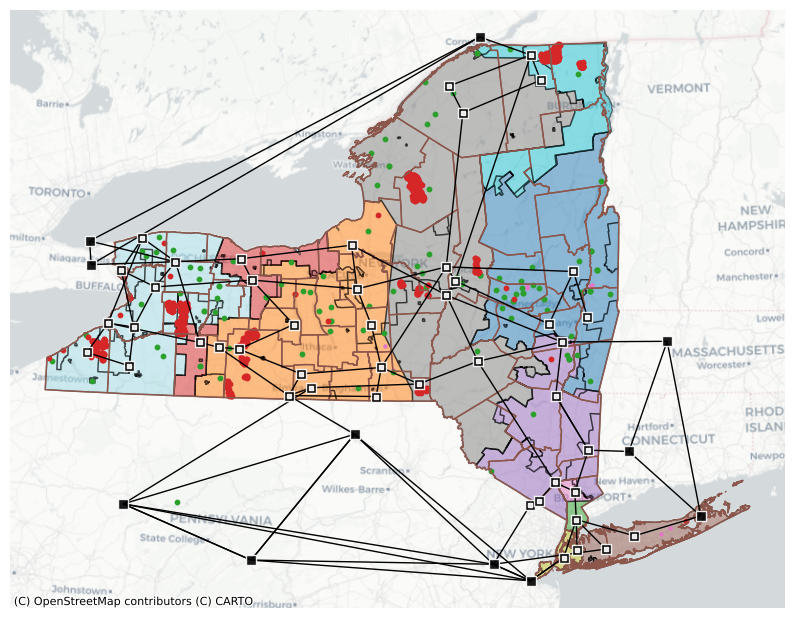

In [ ]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# NYISO zones
ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20', alpha=0.5, edgecolor='k')

# NYGrid buses and buses in NYS
ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

# NYGrid branches
ax = nygrid_branch_32618.plot(ax=ax, color='black', linewidth=1)

# Current solar
ax = current_upv_info_32618.plot(ax=ax, color='tab:pink', markersize=5)

# Future solar
ax = future_upv_info_32618.plot(ax=ax, color='tab:green', markersize=10)

# Onshore wind
ax = current_wind_info_32618.plot(ax=ax, color='tab:red', markersize=10)

# Counties boundaries
ax = counties_32618.plot(ax=ax, color='none', edgecolor='tab:brown', lw=1)

# ax.title.set_text('Renewable resource allocation to NYGrid buses')
ax.set_axis_off()

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=current_upv_info_32618.crs)

fig.savefig(os.path.join(fig_dir, 'renewable_allocation.png'), dpi=600,
            bbox_inches='tight')